In [5]:
import os
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from itertools import combinations

DATA_PATH = "/home/kartik/layout-analysis/stress-test-data"
SAMPLE_SIZE = 6  

In [6]:
#HYPERPARAMETERS
NUM_NEIGHBOURS = 16
# filter top 8 neighbours
# filter only opposite 
# filter only 'horizontal' (AI)
# filter only the shortest 
# if one of the two connections is too long, cut it (AI)

Processing file: /home/kartik/layout-analysis/stress-test-data/pg_2_points.txt


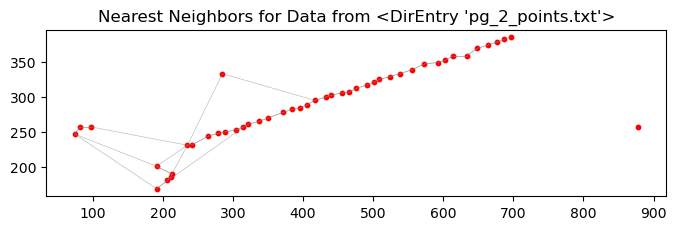

Processing file: /home/kartik/layout-analysis/stress-test-data/pg_0_points.txt


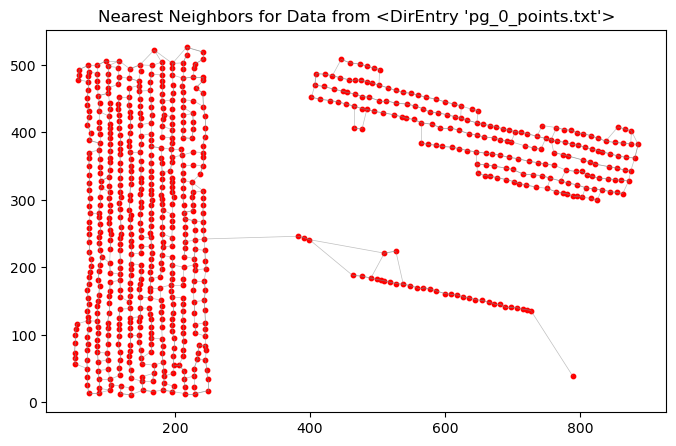

Processing file: /home/kartik/layout-analysis/stress-test-data/pg_5_points.txt


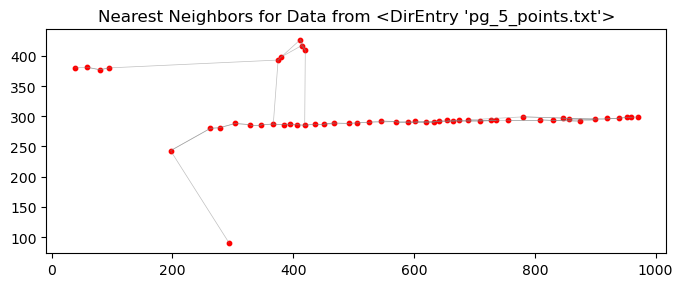

Processing file: /home/kartik/layout-analysis/stress-test-data/pg_4_points.txt


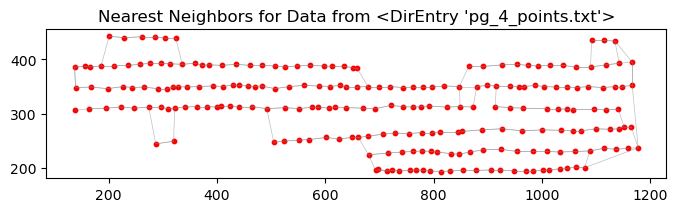

Processing file: /home/kartik/layout-analysis/stress-test-data/pg_1_points.txt


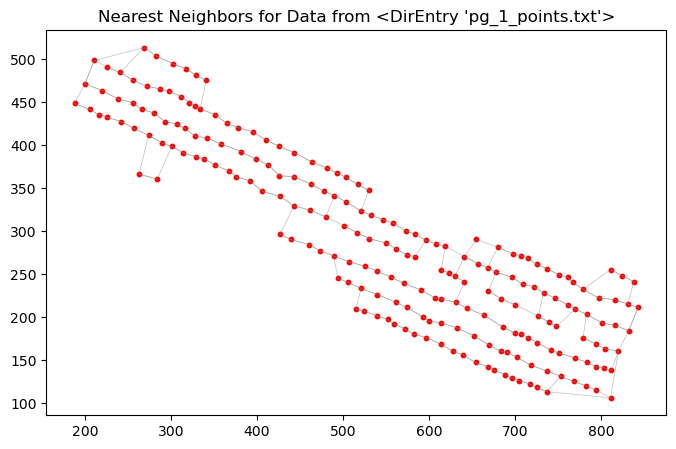

Processing file: /home/kartik/layout-analysis/stress-test-data/pg_3_points.txt


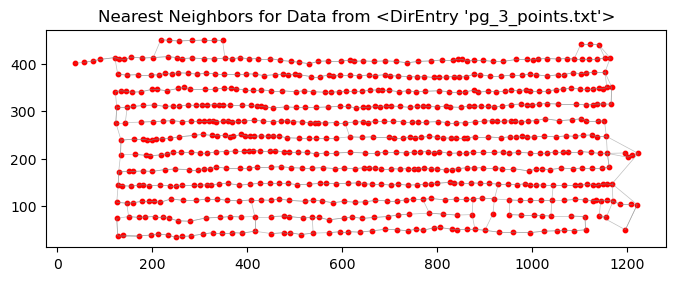

In [24]:
# Get unique prefixes efficiently without sorting everything
for entry in os.scandir(DATA_PATH):
    # Process only files that end with '.txt'
    if entry.is_file() and entry.name.endswith('.txt'):
        points_file = entry.path  # Full path to the current points file
        print(f"Processing file: {points_file}")
        
        # Load the file's contents as a NumPy array (assumed to be point coordinates)
        points = np.loadtxt(points_file)
        
        # Build a KD-tree for fast nearest neighbor lookups based on the points
        tree = cKDTree(points)

        # Query the KD-tree to get indices of the NUM_NEIGHBOURS nearest neighbors for each point
        # We don't use the distances here, so we unpack only the indices.
        _, indices = tree.query(points, k=NUM_NEIGHBOURS)

        segments = []  # This list will store neighbor segments for each point

        # shape of indices is [num of points on the page, nummber of neighbours, including itself 16]
        for current_point_index, nbr_indices in enumerate(indices):
            # Compute the local coordinates of the neighbors relative to the center point (points[i])
            normalized_points = points[nbr_indices] - points[current_point_index]
            #print("Normalized center:", normalized_points[0])  # Expected to be [0,0]
            
            # Use symmetric scaling: find the maximum absolute deviation from the center along each axis.
            scaling_factor = np.max(np.abs(normalized_points), axis=0)
            # Avoid division by zero by replacing zeros in scaling_factor with 1.
            scaling_factor[scaling_factor == 0] = 1
            # Scale the normalized points. Since the center is [0,0], dividing by the scaling factor keeps it unchanged.
            scaled_points = normalized_points / scaling_factor
            #print("Scaled center:", scaled_points[0])  # Remains [0,0]
            
            # Build a list of tuples (global neighbor index, relative vector in scaled space).
            # Here scaled_points[0] is the center (i.e. [0,0]) and for each neighbor we compute the difference.
            relative_neighbours = [(global_idx, sp)
                                for global_idx, sp in zip(nbr_indices, scaled_points)]

            opposite_neighbours = []
            for _a, _b in combinations(relative_neighbours,2):
                relative_vector1 = _a[1]
                relative_vector2 = _b[1]
                if np.dot(relative_vector1, relative_vector2) < 0: # append only if both are opposite
                    opposite_neighbours.append((_a,_b))      

            shortest_neighbours = []
            for _a, _b in opposite_neighbours:
                relative_vector1 = _a[1]
                relative_vector2 = _b[1]

                norm1 = np.linalg.norm(relative_vector1)
                norm2 = np.linalg.norm(relative_vector2)

                total_distance = norm1+norm2
                shortest_neighbours.append((_a,_b,total_distance))

            # filtered_neighbours = []
            # for _a, _b, distance in shortest_neighbours:
            #     relative_vector1 = _a[1]
            #     relative_vector2 = _b[1]
            #     norm1 = np.linalg.norm(relative_vector1)
            #     norm2 = np.linalg.norm(relative_vector2)
            #     # Calculate the cosine similarity between the two vectors
            #     cos_similarity = np.dot(relative_vector1, relative_vector2) / (norm1 * norm2)
            #     # If the vectors are somewhat non-orthogonal (i.e. not nearly perpendicular),
            #     # then include this neighbour pair. Adjust the threshold (0.1) as needed.
            #     if np.abs(cos_similarity) > 0.9:
            #         filtered_neighbours.append((_a, _b, distance))

            if len(shortest_neighbours)!=0:
                shortest_two_neighbours = min(shortest_neighbours, key=lambda x: x[2])
                j_connection_1 = shortest_two_neighbours[0][0]
                j_connection_2 = shortest_two_neighbours[1][0]

                segments.append((points[current_point_index],points[j_connection_1]))
                segments.append((points[current_point_index],points[j_connection_2]))


        
        lc = mc.LineCollection(segments, colors='gray', linewidths=0.5, alpha=0.5)
        
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.add_collection(lc)
        ax.scatter(points[:, 0], points[:, 1], c='red', s=10)
        ax.set_title(f"Nearest Neighbors for Data from {entry}")
        ax.set_aspect('equal')
        plt.show()


In [ ]:
#TODO
# image to heatmap to pointcloud -- has to be consistent
# ensure consistant connection (over scale and rotation)
# anomaly detection - remove
                                
